# Effect of Volker's Rule on BHC Trading Ratios and Risk Taking

## Table of Contents

- [1.Import and Clean Dataset](#section1)
    - [1.1 Add Engineered Features and Create DataFrames](#section1.1)
- [2. Evaluating Changes in Trading Book: Initial Compliance with Volcker Rule](#section2)
    - [2.1 Baseline Tests](#section2.1)
    - [2.2 Robustness Tests](#section2.2)
        - [2.2.1 Treatment Dummy](#section2.2.1)
        - [2.2.2 Propensity Score Matching](#section2.2.2)
        - [2.2.3 Pre-2007 Affectedness Ratio](#section2.2.3)
        - [2.2.4 Excluding non-trading BHCs](#section2.2.4)
- [3. Assessing Changes in Overall Risk (z-score)](#section3)
- [4. Appendix](#section4)
    - [4.1 Propensity Scoring: Comparison of Sample Statistics Before & After Matching](#section4.1)

## 1. Import and Clean Dataset <a class="anchor" id="section1"></a>

In [1]:
# Import all required packages

import numpy as np
import pandas as pd
import datetime as dt

from linearmodels.panel import PooledOLS
from linearmodels.panel import PanelOLS
from linearmodels.panel.results import PanelEffectsResults
from linearmodels.panel import compare

import statsmodels.api as sm
from statsmodels.stats.weightstats import ttest_ind
from sklearn.linear_model import LogisticRegression
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style('ticks')

In [2]:
# Import data and do data integrity checks

df=pd.read_csv('DiD_data.csv')

# Clean headers, date format

df.columns=['bankcode','date','trading_ratio','affected_bhc','after_dfa','roa','leverage','ln_assets','credit_risk','cir','deposit_ratio','loans_re_ratio','liquidity','cpp']
df['date']=pd.to_datetime(df['date'], format='%Y%m%d')

# Initial sense check 

results=df.describe().transpose()
results.reset_index(inplace=True)
results=results.merge(pd.DataFrame(df.isnull().sum()).reset_index(),how='left',on='index')
results=results.rename(columns={0:'missing'})
print('Columns with Missing Values')
print(results[results.missing!=0]['index'].values)
results

Columns with Missing Values
['trading_ratio' 'roa' 'leverage' 'ln_assets' 'credit_risk' 'cir'
 'deposit_ratio' 'loans_re_ratio' 'liquidity']


,index,count,mean,std,min,25%,50%,75%,max,missing
0,bankcode,81560.0,1.803535e+06,803001.252533,1.020180e+06,1.118434e+06,1.248304e+06,2.537957e+06,3.836442e+06,0
1,trading_ratio,41442.0,2.650423e-03,0.020015,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,4.297271e-01,40118
2,affected_bhc,81560.0,1.248161e-02,0.111022,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0
3,after_dfa,81560.0,4.511280e-01,0.497609,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,0
4,roa,56938.0,1.843923e-03,0.006116,-3.871374e-01,1.245900e-03,2.208552e-03,3.119110e-03,9.342769e-01,24622
5,leverage,57017.0,9.351764e-02,0.042513,-7.622810e-01,7.392833e-02,9.015964e-02,1.081844e-01,1.157965e+00,24543
6,ln_assets,61771.0,1.351636e+01,1.354361,5.888878e+00,1.262157e+01,1.323332e+01,1.394826e+01,2.166995e+01,19789
7,credit_risk,44432.0,2.775769e-02,0.033980,0.000000e+00,9.763676e-03,1.804622e-02,3.260448e-02,7.342224e-01,37128
8,cir,42382.0,5.314545e-01,0.355984,-1.247826e+01,4.133833e-01,5.023356e-01,6.152530e-01,4.593333e+01,39178
9,deposit_ratio,79172.0,6.818830e-01,0.112038,0.000000e+00,6.354172e-01,6.966798e-01,7.509852e-01,9.980935e-01,2388


### 1.1 Add Engineered Features and Create DataFrames <a class="anchor" id="section1.1"></a>

In [3]:
# Add qtr column for easier checks

time=pd.DataFrame(sorted(list(df.date.value_counts().index)))
time.columns=['date']
time['qtr']=time.index+1
time['qtr']= ['Q' + str(x) for x in time['qtr']]
df=pd.merge(df,time,on='date',how='left')
df=df.sort_values(by=['bankcode','date'])

In [4]:
# Compute rolling roa_std, affect_2007

roa_std=pd.DataFrame(df.groupby('bankcode', as_index=False)['roa'].rolling(7,min_periods=3).std().values)
alt_affect=pd.DataFrame(df.groupby('bankcode', as_index=False)['trading_ratio'].rolling(15).mean().replace(np.nan,0))
alt_affect['affect_pre2007']=[1 if x>=0.03 else 0 for x in alt_affect['trading_ratio'] ]
alt_affect.columns=['traderatio_roll15','affect_2007']
alt_affect=alt_affect.reset_index()[['affect_2007']]

df= pd.concat([df,roa_std,alt_affect],axis=1)
df.columns=['bankcode', 'date', 'trading_ratio', 'affected_bhc', 'after_dfa', 'roa',
       'leverage', 'ln_assets', 'credit_risk', 'cir', 'deposit_ratio',
       'loans_re_ratio', 'liquidity', 'cpp', 'qtr','roa_vol','affect_2007']

# non_trading_bhc, post_fin_crisis

df['nontrading_bhc']=[1 if x==0 else 0 for x in df['trading_ratio']]
df['post_fin_crisis']=[1 if x>2007 else 0 for x in df['date'].dt.year]
df.head()

,bankcode,date,trading_ratio,affected_bhc,after_dfa,roa,leverage,ln_assets,credit_risk,cir,deposit_ratio,loans_re_ratio,liquidity,cpp,qtr,roa_vol,affect_2007,nontrading_bhc,post_fin_crisis
0,1020180,2004-09-30,0.0,0,0,0.002772,0.081957,15.601202,0.013304,0.463811,0.561805,0.593738,0.024337,0,Q1,NaN,0,1,0
1,1020180,2004-12-31,0.0,0,0,0.003045,0.082480,15.630583,0.009732,0.456392,0.557617,0.601763,0.025446,0,Q2,NaN,0,1,0
2,1020180,2005-03-31,0.0,0,0,0.002616,0.082074,15.644925,0.011830,0.444011,0.556980,0.600700,0.025153,0,Q3,0.000217,0,1,0
3,1020180,2005-06-30,0.0,0,0,0.002647,0.081712,15.679702,0.013654,0.433771,0.571642,0.601042,0.023670,0,Q4,0.000196,0,1,0
4,1020180,2005-09-30,0.0,0,0,0.002867,0.082944,15.661868,0.012456,0.400985,0.577408,0.581438,0.029793,0,Q5,0.000175,0,1,0


In [5]:
# Add in affect (average trading ratio for pre dfa), interaction term
filt_predfa=(df['date']>='2004-07-01') & (df['date']<='2009-06-30')
affect_df=df[['bankcode','date','trading_ratio']][filt_predfa]

affect_df=affect_df.groupby('bankcode',as_index=False)['trading_ratio'].mean()
affect_df.columns=['bankcode','affect']
df=df.merge(affect_df,how='left',on='bankcode')

# Add in affect-2007 (average trading ratio for pre financial crisis), interaction terms
filt_predfa=(df['date']>='2004-07-01') & (df['date']<='2007-01-01')
affect_df=df[['bankcode','date','trading_ratio']][filt_predfa]

affect_df=affect_df.groupby('bankcode',as_index=False)['trading_ratio'].mean()
affect_df.columns=['bankcode','affectpfc']
df=df.merge(affect_df,how='left',on='bankcode')

# Interactions terms
df['afterdfa*affect']=df['after_dfa']*df['affect']
df['afterdfa*affectpfc']=df['after_dfa']*df['affectpfc']
df['afterdfa*affectbhc']=df['after_dfa']*df['affected_bhc']

df.head()
print(len(df))

81560


In [6]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
bankcode,81560.0,1.803535e+06,803001.252533,1.020180e+06,1.118434e+06,1.248304e+06,2.537957e+06,3.836442e+06
trading_ratio,41442.0,2.650423e-03,0.020015,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,4.297271e-01
affected_bhc,81560.0,1.248161e-02,0.111022,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00
after_dfa,81560.0,4.511280e-01,0.497609,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00
roa,56938.0,1.843923e-03,0.006116,-3.871374e-01,1.245900e-03,2.208552e-03,3.119110e-03,9.342769e-01
leverage,57017.0,9.351764e-02,0.042513,-7.622810e-01,7.392833e-02,9.015964e-02,1.081844e-01,1.157965e+00
ln_assets,61771.0,1.351636e+01,1.354361,5.888878e+00,1.262157e+01,1.323332e+01,1.394826e+01,2.166995e+01
credit_risk,44432.0,2.775769e-02,0.033980,0.000000e+00,9.763676e-03,1.804622e-02,3.260448e-02,7.342224e-01
cir,42382.0,5.314545e-01,0.355984,-1.247826e+01,4.133833e-01,5.023356e-01,6.152530e-01,4.593333e+01
deposit_ratio,79172.0,6.818830e-01,0.112038,0.000000e+00,6.354172e-01,6.966798e-01,7.509852e-01,9.980935e-01


In [7]:
# DataFrame to use for model 1, drop 40,118 rows with nil trading_ratio values

df_b1= df.dropna(subset=['trading_ratio'])
df_b1.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
bankcode,41442.0,1.759544e+06,805589.140458,1.020180e+06,1.108097e+06,1.209828e+06,2.467474e+06,3.836442e+06
trading_ratio,41442.0,2.650423e-03,0.020015,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,4.297271e-01
affected_bhc,41442.0,1.703586e-02,0.129406,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00
after_dfa,41442.0,4.037933e-01,0.490663,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00
roa,41328.0,1.851036e-03,0.006871,-3.871374e-01,1.298545e-03,2.245943e-03,3.119124e-03,9.342769e-01
leverage,41407.0,9.250672e-02,0.037183,-1.398172e-01,7.392285e-02,8.960092e-02,1.068090e-01,1.157965e+00
ln_assets,41442.0,1.393009e+01,1.426113,5.888878e+00,1.315108e+01,1.361323e+01,1.437415e+01,2.166995e+01
credit_risk,41426.0,2.798249e-02,0.034134,0.000000e+00,9.898671e-03,1.821179e-02,3.288328e-02,7.342224e-01
cir,41362.0,5.326924e-01,0.359555,-1.247826e+01,4.137489e-01,5.034823e-01,6.170951e-01,4.593333e+01
deposit_ratio,41440.0,6.705997e-01,0.129683,0.000000e+00,6.190178e-01,6.892053e-01,7.531588e-01,9.980935e-01


In [8]:
# Replace any infinity values with NaN

pd.options.mode.chained_assignment = None
df_b1.replace([np.inf, -np.inf], np.nan, inplace=True)
print(df_b1.isnull().sum())

bankcode                 0
date                     0
trading_ratio            0
affected_bhc             0
after_dfa                0
roa                    114
leverage                35
ln_assets                0
credit_risk             16
cir                     80
deposit_ratio            2
loans_re_ratio          16
liquidity             1302
cpp                      0
qtr                      0
roa_vol               4331
affect_2007              0
nontrading_bhc           0
post_fin_crisis          0
affect                   0
affectpfc             1321
afterdfa*affect          0
afterdfa*affectpfc    1321
afterdfa*affectbhc       0
dtype: int64


In [9]:
# DataFrame to use for model 2-4, dropped additional 1416 rows based on nil control values

drop_b2_nancols=['roa',
 'leverage',
 'credit_risk',
 'cir',
 'deposit_ratio',
 'loans_re_ratio',
 'liquidity']

df_b2=df_b1.dropna(subset=drop_b2_nancols)
df_b2.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
bankcode,40026.0,1.758412e+06,805063.671465,1.020180e+06,1.107997e+06,1.209716e+06,2.467474e+06,3.836442e+06
trading_ratio,40026.0,2.503848e-03,0.019591,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,4.297271e-01
affected_bhc,40026.0,1.566482e-02,0.124177,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00
after_dfa,40026.0,3.896967e-01,0.487688,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00
roa,40026.0,1.814628e-03,0.004791,-1.241662e-01,1.280377e-03,2.239816e-03,3.120696e-03,1.660869e-01
leverage,40026.0,9.190957e-02,0.035191,-1.367974e-01,7.360926e-02,8.920620e-02,1.063232e-01,6.933124e-01
ln_assets,40026.0,1.388976e+01,1.393736,1.049759e+01,1.313461e+01,1.358267e+01,1.431727e+01,2.166825e+01
credit_risk,40026.0,2.832874e-02,0.034504,0.000000e+00,9.988749e-03,1.846549e-02,3.335707e-02,7.342224e-01
cir,40026.0,5.290953e-01,0.281027,-1.247826e+01,4.120157e-01,5.000958e-01,6.124870e-01,1.782285e+01
deposit_ratio,40026.0,6.732617e-01,0.125551,0.000000e+00,6.215510e-01,6.905751e-01,7.536152e-01,9.980935e-01


In [10]:
# Check if all BHCs are still represented

bhc_all=len(list(df.bankcode.value_counts().index))
bhc_df_b1=len(list(df_b1.bankcode.value_counts().index))
bhc_df_b2=len(list(df_b2.bankcode.value_counts().index))

dfs=['All','Drop Nil Trading Ratios','Drop Nil Control Values']
bhcs=[bhc_all,bhc_df_b1,bhc_df_b2]
pd.DataFrame({'DataFrame': dfs, 'BHC Scope':bhcs}).set_index('DataFrame')

,BHC Scope
DataFrame,
All,2473
Drop Nil Trading Ratios,2473
Drop Nil Control Values,2428


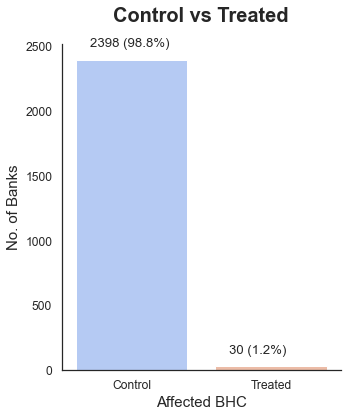

In [11]:
# Visualize number of treatment and control group members

for i in [df_b2]:
  
  df_group = i[['bankcode', 'affected_bhc']].drop_duplicates()

  sns.set(style='white',font_scale=1.1)
  fig = plt.figure(figsize=[5,6])
  ax = sns.countplot(data=df_group,x='affected_bhc',palette='coolwarm')
  ax.set_xticklabels(['Control','Treated'])
  for p in ax.patches:
          ax.annotate(str(p.get_height())+' ('+str((p.get_height()/len(df_group)*100).round(1))+'%)', (p.get_x()+0.1, p.get_height()+100))
  plt.title('Control vs Treated', weight='bold', fontsize = 20, y=1.05)
  plt.xlabel('Affected BHC', fontsize = 15)   
  plt.ylabel('No. of Banks', fontsize = 15)   
  sns.despine()

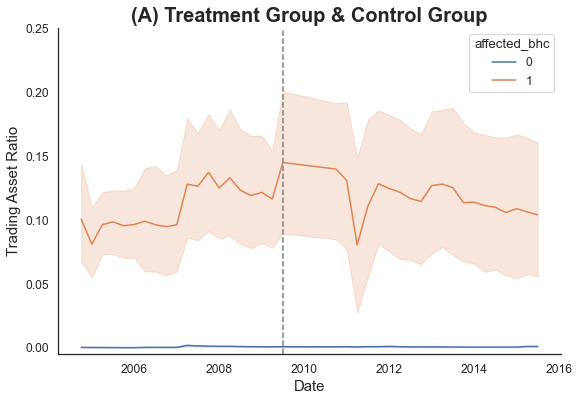

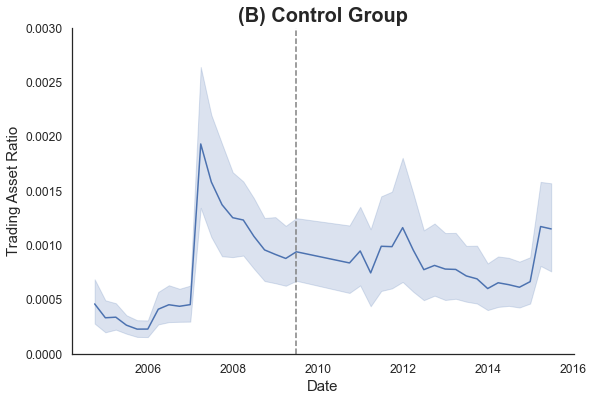

In [12]:
# Check the average trading ratio by affected_bhc and control_bhc over time

for i in [df_b1]:
    
    # Plot Treatment vs Control
    fig = plt.figure(figsize=[9,6])
    sns.lineplot(x="date", y="trading_ratio", 
              hue="affected_bhc", data=i, ci = 95).axvline('2009-06-30 00:00:00', color='grey', linestyle = '--')
    plt.ylim(-0.005,0.25)
    plt.title('(A) Treatment Group & Control Group', fontweight="bold", fontsize = 20)
    plt.xlabel('Date', fontsize = 15)   
    plt.ylabel('Trading Asset Ratio', fontsize = 15)
    sns.despine()
    
    # Plot Control Only
    control = i[i['affected_bhc']==0]
    fig = plt.figure(figsize=[9,6])
    sns.lineplot(x="date", y="trading_ratio", 
                 data=control, ci = 95).axvline('2009-06-30 00:00:00', color='grey', linestyle = '--')
    plt.ylim(0,0.003)
    plt.title('(B) Control Group', fontweight="bold", fontsize = 20)
    plt.xlabel('Date', fontsize = 15)   
    plt.ylabel('Trading Asset Ratio', fontsize = 15)
    sns.despine()

## 2. Evaluating Changes in Trading Book: Initial Compliance with Volcker Rule <a class="anchor" id="section2"></a>

### 2.1 Baseline Tests<a class="anchor" id="section2.1"></a>

We proceed to test our overall model as formulated for BHC $i$ in quarter $t$:
\begin{equation}
    \begin{aligned}
    Y_{i,t} = & \alpha + \beta_1 * after DFA_t + \beta_2 * AFFECT_i\\
              & + \beta_3 * (after DFA_t * AFFECT_i)\\
              & + \gamma_i + \delta_t + X_{i,t} + \epsilon_{i,t}\\
    \end{aligned}
\end{equation}

#### Model 1:  After_DFA without controls or fixed effects

In [13]:
df_test=df_b1.copy()
df_test = df_test.set_index(['bankcode', 'date'])

y = df_test['trading_ratio']
X = df_test['after_dfa']
X = sm.add_constant(X)
base_1 = sm.OLS(y,X).fit()
base_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          trading_ratio   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     6.419
Date:                Sun, 24 Oct 2021   Prob (F-statistic):             0.0113
Time:                        23:22:48   Log-Likelihood:             1.0329e+05
No. Observations:               41442   AIC:                        -2.066e+05
Df Residuals:                   41440   BIC:                        -2.066e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0024      0.000     19.207      0.000       0.002       0.003
after_dfa      0.0005      0.000      2.534      0.011       0.000       0.001
==============================================================================
Omnibus:                    71532.559   Durbin-Watson:                   0.198
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         57471366.578
Skew:                          12.333   Prob(JB):                         0.00
Kurtosis:                     183.761   Cond. No.                         2.45
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [14]:
# Expand on decimal places for standard errors from Model 1
print(base_1.bse[1:2])

after_dfa    0.0002
dtype: float64


#### Model 2: After_DFA with controls, without fixed effects.

In [15]:
df_test=df_b2.copy()
df_test = df_test.set_index(['bankcode', 'date'])

y = df_test['trading_ratio']

keep=['after_dfa','ln_assets', 'roa', 'leverage', 'liquidity', 'deposit_ratio',
      'credit_risk','loans_re_ratio', 'cir', 'cpp']

X = df_test[keep]
X = sm.add_constant(X)

base_2 = sm.OLS(y,X).fit()
base_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          trading_ratio   R-squared:                       0.234
Model:                            OLS   Adj. R-squared:                  0.234
Method:                 Least Squares   F-statistic:                     1222.
Date:                Sun, 24 Oct 2021   Prob (F-statistic):               0.00
Time:                        23:22:48   Log-Likelihood:             1.0595e+05
No. Observations:               40026   AIC:                        -2.119e+05
Df Residuals:                   40015   BIC:                        -2.118e+05
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const             -0.0207      0.002    -13.677      0.000      -0.024      -0.018
after_dfa         -0.0010      0.000     -4.868      0.000      -0.001      -0.001
ln_assets          0.0043   7.27e-05     59.434      0.000       0.004       0.004
roa                0.0321      0.022      1.484      0.138      -0.010       0.075
leverage          -0.0495      0.003    -19.054      0.000      -0.055      -0.044
liquidity         -0.0006      0.002     -0.297      0.766      -0.005       0.003
deposit_ratio     -0.0337      0.001    -41.532      0.000      -0.035      -0.032
credit_risk        0.0203      0.003      7.224      0.000       0.015       0.026
loans_re_ratio    -0.0138      0.001    -23.362      0.000      -0.015      -0.013
cir                0.0010      0.000      2.921      0.003       0.000       0.002
cpp               -0.0016      0.000     -4.407      0.000      -0.002      -0.001
==============================================================================
Omnibus:                    63938.993   Durbin-Watson:                   0.174
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         43593657.697
Skew:                          10.478   Prob(JB):                         0.00
Kurtosis:                     163.312   Cond. No.                     3.55e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.55e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [16]:
# Expand on decimal places for standard errors from Model 2
print(base_2.bse[1:2])

after_dfa    0.000213
dtype: float64


#### Model 3: After_DFA,  Affect and After_DFA * Affect with controls, without fixed effects.

In [17]:
df_test=df_b2.copy()
df_test = df_test.set_index(['bankcode', 'date'])

y = df_test['trading_ratio']

keep=['after_dfa', 'affect', 'afterdfa*affect','ln_assets', 'roa', 'leverage', 'liquidity', 'deposit_ratio', 
      'credit_risk','loans_re_ratio', 'cir', 'cpp']

X = df_test[keep]
X = sm.add_constant(X)

full_model = sm.OLS(y,X).fit()
full_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          trading_ratio   R-squared:                       0.902
Model:                            OLS   Adj. R-squared:                  0.902
Method:                 Least Squares   F-statistic:                 3.061e+04
Date:                Sun, 24 Oct 2021   Prob (F-statistic):               0.00
Time:                        23:22:49   Log-Likelihood:             1.4705e+05
No. Observations:               40026   AIC:                        -2.941e+05
Df Residuals:                   40013   BIC:                        -2.940e+05
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              -0.0030      0.001     -5.469      0.000      -0.004      -0.002
after_dfa       -2.039e-05   7.68e-05     -0.266      0.791      -0.000       0.000
affect              0.9925      0.002    402.166      0.000       0.988       0.997
afterdfa*affect    -0.1611      0.003    -52.818      0.000      -0.167      -0.155
ln_assets           0.0002   2.72e-05      8.258      0.000       0.000       0.000
roa                -0.0051      0.008     -0.656      0.512      -0.020       0.010
leverage            0.0013      0.001      1.338      0.181      -0.001       0.003
liquidity          -0.0005      0.001     -0.709      0.479      -0.002       0.001
deposit_ratio       0.0004      0.000      1.298      0.194      -0.000       0.001
credit_risk         0.0017      0.001      1.724      0.085      -0.000       0.004
loans_re_ratio     -0.0007      0.000     -3.500      0.000      -0.001      -0.000
cir                 0.0002      0.000      1.465      0.143   -6.33e-05       0.000
cpp                -0.0002      0.000     -1.936      0.053      -0.000    3.08e-06
==============================================================================
Omnibus:                    51911.637   Durbin-Watson:                   0.524
Prob(Omnibus):                  0.000   Jarque-Bera (JB):        103525182.575
Skew:                           6.371   Prob(JB):                         0.00
Kurtosis:                     251.822   Cond. No.                     3.55e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.55e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [18]:
# Expand on decimal places for standard errors from Model 3
print(full_model.bse[1:4])

after_dfa          0.000077
affect             0.002468
afterdfa*affect    0.003051
dtype: float64


#### Model 4: After_DFA * Affect with controls and fixed effects.

In [19]:
df_fe=df_b2.copy()
df_fe['bankcodecluster'] = df_fe['bankcode']

keep=['afterdfa*affect','ln_assets', 'roa', 'leverage', 'liquidity', 'deposit_ratio', 
      'credit_risk','loans_re_ratio', 'cir', 'cpp', 'bankcode','date','bankcodecluster']

X_clean = df_fe[keep]
X_clean=pd.get_dummies(data=X_clean,columns=['bankcode','date']) 

X = X_clean.drop(['bankcodecluster'], axis = 1)

y=df_fe['trading_ratio']

# Specify clustering to ensure standard errors are clustered by bankcode
full_model_fe = sm.OLS(y,X).fit(cov_type = 'cluster', cov_kwds={'groups': X_clean['bankcodecluster']})

In [20]:
# Define a function to print out statsmodel statistics excluding fixed effects dummies
def sm_summary(model):
    params = model.params[0:10]
    stderr = model.bse[0:10]
    pval = model.pvalues[0:10]
    tstat = model.tvalues[0:10]
    summary_statistics = {'beta':params, 'std_error': stderr, 'p-value': pval, 'tstat': tstat}
    summary = pd.DataFrame(summary_statistics).round(4)
    print('Results (fixed effects parameters not shown):')
    print('R-squared:'+str(round(model.rsquared,4)))
    print('Number of observations:'+str(model.nobs))
    print('Errors clustered at the entity level.')
    return summary

In [21]:
sm_summary(full_model_fe)

Results (fixed effects parameters not shown):
R-squared:0.9253
Number of observations:40026.0
Errors clustered at the entity level.


,beta,std_error,p-value,tstat
afterdfa*affect,-0.2024,0.0470,0.0000,-4.3047
ln_assets,-0.0002,0.0005,0.7499,-0.3188
roa,0.0064,0.0080,0.4211,0.8045
leverage,0.0048,0.0038,0.2065,1.2633
liquidity,-0.0012,0.0028,0.6596,-0.4405
deposit_ratio,0.0007,0.0011,0.5409,0.6114
credit_risk,0.0010,0.0019,0.6133,0.5053
loans_re_ratio,-0.0103,0.0046,0.0242,-2.2539
cir,0.0003,0.0002,0.0569,1.9042
cpp,-0.0000,0.0004,0.9878,-0.0152


### 2.2 Robustness Tests <a class="anchor" id="section2.2"></a>

### 2.2.1 Treatment Dummy<a class="anchor" id="section2.2.1"></a>

#### Run Model 4 with treatment dummy (After_DFA * AffectedBHC) instead of interaction term (After_DFA * Affect).

In [22]:
df_fe=df_b2.copy()
df_fe['bankcodecluster'] = df_fe['bankcode']

keep=['afterdfa*affectbhc','ln_assets', 'roa', 'leverage', 'liquidity', 'deposit_ratio', 
      'credit_risk','loans_re_ratio', 'cir', 'cpp', 'bankcode','date', 'bankcodecluster']

X_clean = df_fe[keep]
X_clean=pd.get_dummies(data=X_clean,columns=['bankcode','date']) 

X = X_clean.drop(['bankcodecluster'], axis = 1)

y=df_fe['trading_ratio']

# Specify clustering to ensure standard errors are clustered by bankcode
treatdum_fe = sm.OLS(y,X).fit(cov_type = 'cluster', cov_kwds={'groups': X_clean['bankcodecluster']})

sm_summary(treatdum_fe)

Results (fixed effects parameters not shown):
R-squared:0.9229
Number of observations:40026.0
Errors clustered at the entity level.


,beta,std_error,p-value,tstat
afterdfa*affectbhc,-0.0234,0.0088,0.0079,-2.6571
ln_assets,-0.0001,0.0005,0.8293,-0.2155
roa,0.0062,0.0077,0.4196,0.8072
leverage,0.0022,0.0048,0.6488,0.4554
liquidity,-0.0004,0.0030,0.8922,-0.1355
deposit_ratio,0.0008,0.0012,0.5382,0.6155
credit_risk,-0.0000,0.0020,0.9928,-0.0090
loans_re_ratio,-0.0096,0.0046,0.0381,-2.0741
cir,0.0003,0.0002,0.0642,1.8508
cpp,-0.0002,0.0005,0.6781,-0.4150


In [23]:
# Finding mean of trading_ratio for affected BHCs only
tradingratio_afbhc = df_b2[df_b2['affected_bhc']==1][df_b2['after_dfa']==0]['trading_ratio'].mean()
print('Mean trading ratio of affected BHCs before DFA:{a:.2f}%'.format(a=tradingratio_afbhc*100.0))

Mean trading ratio of affected BHCs before DFA:11.36%


<ipython-input-23-98230e34738c>:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  tradingratio_afbhc = df_b2[df_b2['affected_bhc']==1][df_b2['after_dfa']==0]['trading_ratio'].mean()


### 2.2.2 Propensity Score Matching <a class="anchor" id="section2.2.2"></a>

#### Select a control group using Propensity Score Matching

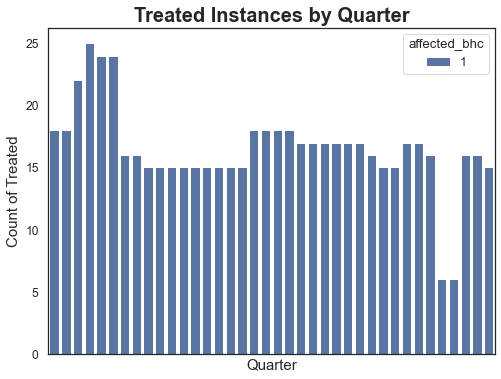

In [24]:
# The following shows that the 4th quarter of data is most appropriate to run propensity score 
# matching with max number of control samples.

fig = plt.figure(figsize=[8,6])
sns.countplot(x='date', hue="affected_bhc", data=df_b2[df_b2['affected_bhc']==1])
plt.title('Treated Instances by Quarter', fontweight="bold", fontsize = 20)
plt.xlabel('Quarter', fontsize = 15)   
plt.ylabel('Count of Treated', fontsize = 15)
plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False) 
plt.show()

#### Filter out 2005-06-30 quarter data to perform Propensity Scoring and Matching

In [25]:
# Use 2005-06-30 (Captures 25 affected_bha)
df_prop = df_b2[df_b2['date'] == '2005-06-30 00:00:00']

# Keep only the factors which contribute to similarity of banks in receiving treatment (>3% trading asset ratio)
df_prop = df_prop[['bankcode', 'affected_bhc', 'ln_assets', 'leverage', 'roa', 'liquidity', 
                   'deposit_ratio', 'loans_re_ratio', 'cir', 'credit_risk']]

# Reset index, preserve bankcode to link back
df_prop.reset_index(inplace = True, drop=True)

# Dataframe of bank features 
df_prop.head()

,bankcode,affected_bhc,ln_assets,leverage,roa,liquidity,deposit_ratio,loans_re_ratio,cir,credit_risk
0,1020180,0,15.679702,0.081712,0.002647,0.023670,0.571642,0.601042,0.433771,0.013654
1,1020201,1,18.788057,0.078767,0.001485,0.046566,0.362995,0.642943,0.372252,0.015216
2,1020395,0,12.374304,0.071236,0.005520,0.045001,0.697034,0.692422,0.350210,0.009197
3,1020582,0,12.402913,0.124981,0.005700,0.032582,0.634618,0.779218,0.378423,0.004032
4,1020676,0,13.421321,0.046549,0.000888,0.028740,0.534096,0.638958,0.669077,0.036593


##### Perform Scoring using Logistic Regression

In [26]:
# Set a random seed
np.random.seed(1111)

# Split into X and y for Logistic Regression
X = df_prop[['ln_assets', 'leverage', 'roa', 'liquidity', 'deposit_ratio', 'loans_re_ratio', 'cir','credit_risk']]
y = df_prop['affected_bhc']

# Initialize a Logistic Regression classifier with a large C to turn off regularisation
propensity = LogisticRegression(C = 100)
propensity.fit(X, y)

# Get propensity score (probability that bank is in class 1)
pscore = propensity.predict_proba(X)
df_prop['propensity_score'] = pscore[:,1]

# Take only the columns with propensity scores to do matching
prop_cols = ['bankcode','propensity_score']
df_prop_control = df_prop[df_prop['affected_bhc']==0][prop_cols]
df_prop_treated = df_prop[df_prop['affected_bhc']==1][prop_cols]

# Shuffle the treated group and reset index for for-loop
df_prop_treated_reset = df_prop_treated.sample(frac=1).reset_index(drop=True)

# Match only the nearest neighbour
n = 1

# Set index of control as bankcodes to allow joining later
df_dist = df_prop_control.set_index('bankcode')

# Set up a list to collect the indices of matched pairs
matched = []

# For each point in treated, find the index locations in the control group with the closest score
for i in range(len(df_prop_treated_reset)):
    df_dist['diff'] = df_dist['propensity_score'] - df_prop_treated_reset.iloc[i,1]
    
    # Select point(s) with the closest absolute value difference from the treated point
    closest = df_dist[['diff']].abs().nsmallest(columns = 'diff', n=n)
    
    # Remove sampled point from the dataset (sampling without replacement)
    df_dist = df_dist.drop(closest.index)
    
    # Collect the n closest points for each treatment point and the treatment point
    matched.append(closest.index.to_list())
    matched.append([df_prop_treated_reset.iloc[i,0]])

# Unpack the selected control list
matched_unpack = []
for sublist in matched:
    for item in sublist:
        matched_unpack.append(item)

# Convert selected controls + treatment list to a DataFrame
matched_df = pd.DataFrame(matched_unpack, columns =['bankcode'])

# Use selected control list to innerjoin the propensity df and recover details
matched_df = pd.merge(df_prop, matched_df, on='bankcode')

# Final dataframe with 25 test instances matched with 25 control instances
# Sort by the order of matching
sorter = matched_unpack
matched_df['bankcode'] = matched_df['bankcode'].astype("category")
matched_df['bankcode'].cat.set_categories(sorter, inplace=True)
matched_df.sort_values(['bankcode'],inplace=True)

print('Rows: '+str(len(matched_df)))
matched_df

Rows: 50


,bankcode,affected_bhc,ln_assets,leverage,roa,liquidity,deposit_ratio,loans_re_ratio,cir,credit_risk,propensity_score
38,2307280,0,17.653505,0.024267,0.000724,0.051802,0.020084,0.096453,0.169943,0.005400,0.808690
41,2816906,1,19.718945,0.012703,0.000816,0.095237,0.014958,0.281824,0.210076,0.012355,0.916653
44,2945824,0,19.759441,0.068822,0.006034,0.000520,0.008836,0.753158,0.825331,0.002539,0.645551
33,1951350,1,21.160093,0.073600,0.003340,0.037994,0.109765,0.383825,0.395564,0.028513,0.923534
11,1071191,0,13.632062,0.094215,0.002407,0.033870,0.696862,0.644261,0.446683,0.014095,0.002644
30,1417360,1,12.464819,0.066302,0.001457,0.020476,0.535435,0.568976,0.514551,0.009012,0.002646
8,1068762,0,17.428902,0.111515,0.003359,0.138654,0.249106,0.366019,0.634348,0.004448,0.241432
22,1131787,1,18.945129,0.098125,0.002791,0.026055,0.473088,0.587738,0.448842,0.011262,0.240203
23,1199563,0,16.849295,0.097834,0.003582,0.018513,0.478164,0.706010,0.357780,0.014888,0.061500
14,1094640,1,17.430975,0.059120,0.002840,0.024599,0.479826,0.785421,0.536421,0.014529,0.060122


In [27]:
# Find all banks where affected_bhc = 0 and NOT selected as control from the larger df dataset
df_control = df_b2[df_b2['affected_bhc'] == 0]
df_treated = df_b2[df_b2['affected_bhc'] == 1]
matched_control = matched_df[matched_df['affected_bhc'] == 0]['bankcode']

# Use inner join to filter out only matched banks' data
df_control_new = pd.merge(df_control, matched_control, on='bankcode')

# Now regression can be run as per normal using df_matched
df_matched = pd.concat([df_control_new,df_treated])

# Total number of records left after propensity score matching
print(len(df_matched))
df_matched.head()

1228


,bankcode,date,trading_ratio,affected_bhc,after_dfa,roa,leverage,ln_assets,credit_risk,cir,...,qtr,roa_vol,affect_2007,nontrading_bhc,post_fin_crisis,affect,affectpfc,afterdfa*affect,afterdfa*affectpfc,afterdfa*affectbhc
0,1026632,2004-09-30,0.016441,0,0,-0.000870,0.099590,17.642731,0.000499,0.855045,...,Q1,NaN,0,0,0,0.008199,0.008124,0.0,0.0,0
1,1026632,2004-12-31,0.012458,0,0,0.001124,0.096071,17.668482,0.003892,0.778730,...,Q2,0.000237,0,0,0,0.008199,0.008124,0.0,0.0,0
2,1026632,2005-03-31,0.010848,0,0,0.003098,0.092590,17.652916,0.002742,0.675167,...,Q3,0.000205,0,0,0,0.008199,0.008124,0.0,0.0,0
3,1026632,2005-06-30,0.006535,0,0,0.004015,0.092517,17.654425,0.000836,0.624425,...,Q4,0.000251,0,0,0,0.008199,0.008124,0.0,0.0,0
4,1026632,2005-09-30,0.005510,0,0,0.004498,0.094363,17.630426,0.000541,0.615542,...,Q5,0.000239,0,0,0,0.008199,0.008124,0.0,0.0,0


#### Run Model 4 with matched sample and After_DFA * AffectedBHC.

In [28]:
df_fe=df_matched.copy()
df_fe['bankcodecluster'] = df_fe['bankcode']

keep=['afterdfa*affectbhc','ln_assets', 'roa', 'leverage', 'liquidity', 'deposit_ratio', 
      'credit_risk','loans_re_ratio', 'cir', 'cpp', 'bankcode','date', 'bankcodecluster']

X_clean = df_fe[keep]
X_clean=pd.get_dummies(data=X_clean,columns=['bankcode','date']) 

X = X_clean.drop(['bankcodecluster'], axis = 1)

y=df_fe['trading_ratio']

# Specify clustering to ensure standard errors are clustered by bankcode
propscore_fe = sm.OLS(y,X).fit(cov_type = 'cluster', cov_kwds={'groups': X_clean['bankcodecluster']})
sm_summary(propscore_fe)

Results (fixed effects parameters not shown):
R-squared:0.9372
Number of observations:1228.0
Errors clustered at the entity level.


,beta,std_error,p-value,tstat
afterdfa*affectbhc,-0.0291,0.0096,0.0025,-3.0259
ln_assets,-0.0005,0.0095,0.9607,-0.0493
roa,-0.4521,0.2680,0.0916,-1.6871
leverage,0.0490,0.1540,0.7505,0.3180
liquidity,-0.0182,0.0581,0.7544,-0.3129
deposit_ratio,0.0807,0.0494,0.1026,1.6323
credit_risk,0.1018,0.0731,0.1638,1.3924
loans_re_ratio,-0.0996,0.0425,0.0191,-2.3441
cir,0.0007,0.0005,0.1662,1.3845
cpp,-0.0040,0.0075,0.5994,-0.5252


### 2.2.3 Pre-2007 Affectedness Ratio<a class="anchor" id="section2.2.3"></a>

#### Run Model 4 with After_DFA * Affect (pre-2007) (known as afterdfa*affectpfc).

In [29]:
drop_b3_nancols=['affectpfc','afterdfa*affectpfc']

df_b3=df_b2.dropna(subset=drop_b3_nancols)

In [30]:
df_fe=df_b3.copy()
df_fe['bankcodecluster'] = df_fe['bankcode']

keep=['afterdfa*affectpfc','ln_assets', 'roa', 'leverage', 'liquidity', 'deposit_ratio', 
      'credit_risk','loans_re_ratio', 'cir', 'cpp', 'bankcode','date', 'bankcodecluster']

X_clean = df_fe[keep]
X_clean=pd.get_dummies(data=X_clean,columns=['bankcode','date']) 

X = X_clean.drop(['bankcodecluster'], axis = 1)

y=df_fe['trading_ratio']

# Specify clustering to ensure standard errors are clustered by bankcode
pfc_fe = sm.OLS(y,X).fit(cov_type = 'cluster', cov_kwds={'groups': X_clean['bankcodecluster']})

sm_summary(pfc_fe)

Results (fixed effects parameters not shown):
R-squared:0.8939
Number of observations:38783.0
Errors clustered at the entity level.


,beta,std_error,p-value,tstat
afterdfa*affectpfc,-0.2052,0.0578,0.0004,-3.5530
ln_assets,-0.0002,0.0005,0.6499,-0.4539
roa,0.0123,0.0079,0.1196,1.5566
leverage,0.0056,0.0040,0.1609,1.4021
liquidity,-0.0024,0.0029,0.4054,-0.8321
deposit_ratio,0.0004,0.0011,0.7427,0.3282
credit_risk,0.0021,0.0020,0.2933,1.0508
loans_re_ratio,-0.0068,0.0037,0.0618,-1.8677
cir,0.0004,0.0002,0.0356,2.1015
cpp,0.0001,0.0004,0.7676,0.2955


### 2.2.4 Excluding non-trading BHCs<a class="anchor" id="section2.2.4"></a>

#### Run Model 4 with After_DFA * Affect (pre-2007) (known as afterdfa*affectpfc), excluding non-trading BHCs.

In [31]:
df_fe=df_b3.copy()
df_fe = df_fe[df_fe['nontrading_bhc']==0]
df_fe['bankcodecluster'] = df_fe['bankcode']

keep=['afterdfa*affectpfc','ln_assets', 'roa', 'leverage', 'liquidity', 'deposit_ratio', 
      'credit_risk','loans_re_ratio', 'cir', 'cpp', 'bankcode','date', 'bankcodecluster']

X_clean = df_fe[keep]
X_clean=pd.get_dummies(data=X_clean,columns=['bankcode','date']) 

X = X_clean.drop(['bankcodecluster'], axis = 1)

y=df_fe['trading_ratio']

# Specify clustering to ensure standard errors are clustered by bankcode
ntbhc_fe = sm.OLS(y,X).fit(cov_type = 'cluster', cov_kwds={'groups': X_clean['bankcodecluster']})

sm_summary(ntbhc_fe)

Results (fixed effects parameters not shown):
R-squared:0.9108
Number of observations:4493.0
Errors clustered at the entity level.


,beta,std_error,p-value,tstat
afterdfa*affectpfc,-0.1858,0.0601,0.0020,-3.0938
ln_assets,0.0014,0.0044,0.7451,0.3251
roa,0.0431,0.0520,0.4070,0.8292
leverage,0.0361,0.0498,0.4690,0.7241
liquidity,-0.0107,0.0162,0.5092,-0.6601
deposit_ratio,0.0012,0.0078,0.8743,0.1582
credit_risk,0.0328,0.0226,0.1461,1.4536
loans_re_ratio,-0.0315,0.0214,0.1400,-1.4757
cir,0.0012,0.0005,0.0132,2.4787
cpp,-0.0006,0.0024,0.7898,-0.2666


## 4. Appendix <a class="anchor" id="section4"></a>

### 4.1 Propensity Scoring: Comparison of Sample Statistics Before & After Matching<a class="anchor" id="section4.1"></a>

The following plots show that the matched sample has much closer propensity scores to the treated sample, which can help to control for confounding variables between both samples despite loss of data.

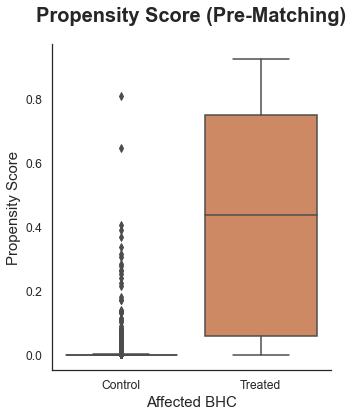

In [32]:
fig = plt.figure(figsize=[5,6])
ax = sns.boxplot(x="affected_bhc", y="propensity_score", data=df_prop)
ax.set_xticklabels(['Control','Treated'])
plt.xlabel('Affected BHC', fontsize = 15)   
plt.ylabel('Propensity Score', fontsize = 15)   
plt.title('Propensity Score (Pre-Matching)', weight='bold', fontsize = 20, y=1.05)
sns.despine()

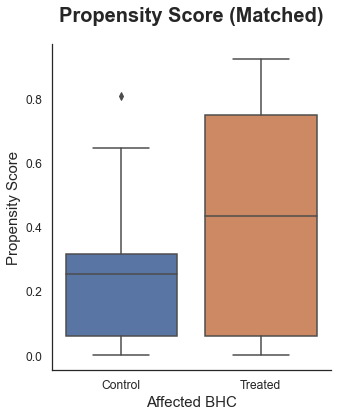

In [33]:
fig = plt.figure(figsize=[5,6])
ax = sns.boxplot(x="affected_bhc", y="propensity_score", data=matched_df)
ax.set_xticklabels(['Control','Treated'])
plt.xlabel('Affected BHC', fontsize = 15)   
plt.ylabel('Propensity Score', fontsize = 15)   
plt.title('Propensity Score (Matched)', weight='bold', fontsize = 20, y=1.05)
sns.despine()

Prior to matching, control and treated groups were significantly different (at p < 0.05) for <b> ln_assets, liquidity, deposit_ratio and loans_re_ratio</b>. 

After matching, only <b>roa</b> is significantly different. 

In [34]:
# Summary Statistics Before Matching
prop_control = df_prop[df_prop['affected_bhc'] == 0]
prop_treated = df_prop[df_prop['affected_bhc'] == 1]

summary_cols = ['ln_assets', 'leverage', 'roa', 'liquidity', 'deposit_ratio', 'loans_re_ratio', 'cir', 'credit_risk']
mean_control = prop_control[summary_cols].mean()
std_control = prop_control[summary_cols].std()
mean_treated = prop_treated[summary_cols].mean()
std_treated = prop_treated[summary_cols].std()
summary_statistics = {'mean_control':mean_control, 'std_control': std_control,
                     'mean_treated': mean_treated, 'std_treated': std_treated}

# Create DataFrame
df_summary = pd.DataFrame(summary_statistics)
df_summary['mean_diff'] = df_summary['mean_control'] - df_summary['mean_treated']

# T-test to calculate significance of difference in means
pval = []
tstat = []

for i in range(2,10):
    tstat_calc = ttest_ind(prop_control.iloc[:,i], prop_treated.iloc[:,i])[0]
    tstat.append(tstat_calc)
    pval_calc = ttest_ind(prop_control.iloc[:,i], prop_treated.iloc[:,i])[1]
    pval.append(pval_calc)

df_summary['diff_pval'] = pval
df_summary['diff_tstat'] = tstat
df_summary['diff_stderr'] = df_summary['mean_diff']/df_summary['diff_tstat']

df_summary = df_summary.round(decimals = 3)
print('Summary Statistics Before Matching:')
df_summary

Summary Statistics Before Matching:


,mean_control,std_control,mean_treated,std_treated,mean_diff,diff_pval,diff_tstat,diff_stderr
ln_assets,13.063,1.116,17.824,2.774,-4.761,0.000,-20.648,0.231
leverage,0.090,0.034,0.083,0.043,0.008,0.256,1.136,0.007
roa,0.003,0.002,0.003,0.002,0.000,0.422,0.804,0.000
liquidity,0.037,0.028,0.052,0.047,-0.015,0.009,-2.633,0.006
deposit_ratio,0.672,0.106,0.317,0.214,0.355,0.000,16.411,0.022
loans_re_ratio,0.727,0.148,0.495,0.256,0.233,0.000,7.758,0.030
cir,0.462,0.108,0.429,0.128,0.033,0.132,1.508,0.022
credit_risk,0.015,0.014,0.016,0.011,-0.001,0.824,-0.223,0.003


In [35]:
# Summary Statistics After Matching
matched_control = matched_df[matched_df['affected_bhc'] == 0]

mean_control = matched_control[summary_cols].mean()
std_control = matched_control[summary_cols].std()
mean_treated = prop_treated[summary_cols].mean()
std_treated = prop_treated[summary_cols].std()
summary_statistics = {'mean_control':mean_control, 'std_control': std_control,
                     'mean_treated': mean_treated, 'std_treated': std_treated}

# Create DataFrame
df_summary = pd.DataFrame(summary_statistics)
df_summary['mean_diff'] = df_summary['mean_control'] - df_summary['mean_treated']

# T-test to calculate significance of difference in means
pval = []
tstat = []

for i in range(2,10):
    tstat_calc = ttest_ind(matched_control.iloc[:,i], prop_treated.iloc[:,i])[0]
    tstat.append(tstat_calc)
    pval_calc = ttest_ind(matched_control.iloc[:,i], prop_treated.iloc[:,i])[1]
    pval.append(pval_calc)

df_summary['diff_pval'] = pval
df_summary['diff_tstat'] = tstat
df_summary['diff_stderr'] = df_summary['mean_diff']/df_summary['diff_tstat']

df_summary = df_summary.round(decimals = 3)
print('Summary Statistics After Matching:')
df_summary

Summary Statistics After Matching:


,mean_control,std_control,mean_treated,std_treated,mean_diff,diff_pval,diff_tstat,diff_stderr
ln_assets,17.052,2.111,17.824,2.774,-0.771,0.274,-1.106,0.697
leverage,0.094,0.035,0.083,0.043,0.011,0.305,1.036,0.011
roa,0.004,0.002,0.003,0.002,0.001,0.019,2.423,0.001
liquidity,0.058,0.075,0.052,0.047,0.006,0.738,0.336,0.018
deposit_ratio,0.388,0.199,0.317,0.214,0.071,0.232,1.211,0.058
loans_re_ratio,0.509,0.273,0.495,0.256,0.014,0.853,0.186,0.075
cir,0.471,0.167,0.429,0.128,0.042,0.320,1.005,0.042
credit_risk,0.014,0.011,0.016,0.011,-0.002,0.616,-0.505,0.003
